# <center>Построение простейших моделей прогнозирования</center>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Загрузим и отобразим данные об объемах пассажирских авиаперевозок.

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

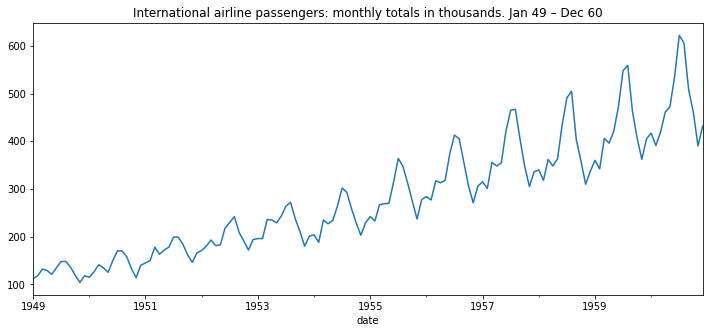

In [3]:
passengers['num_passengers'].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 60')
plt.show()

Временной ряд обладает трендом и годовой сезонностью, которые должны быть учтены при построении моделей прогнозирования. Наличие тренда и сезонности проявляется на коррелограмме. Для построения коррелограммы воспользуемся функцией `plot_acf` из библиотеки `statsmodels`.

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

Опция `lags` позволяет задавать количество лагов для вычисления значений автокорреляции.

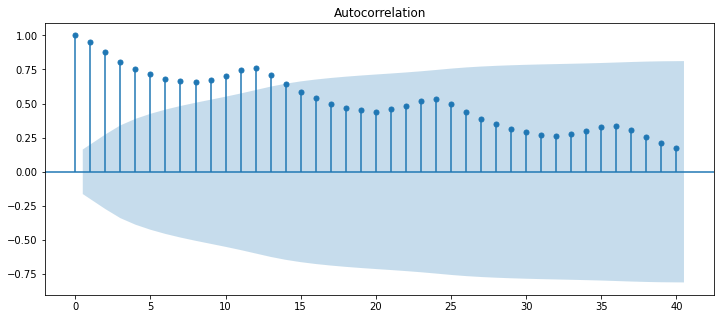

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(passengers['num_passengers'], lags=40, ax=ax)
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
Постройте наивную сезонную модель прогнозирования. Данная модель предполагает, что количество пассажиров в январе 1961 г. будет таким же, как и в январе 1960 г. С помощью полученной модели получите прогноз на 3 года вперед и отобразите результат на графике.
<p></p>
  
</div>

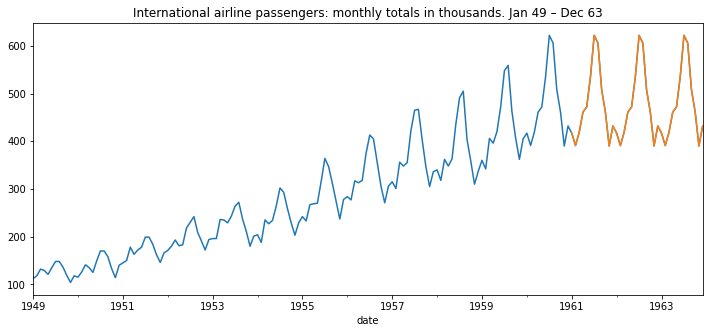

In [6]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)
num_pass=passengers.values.flatten()

n=3 #3 года
date_start=passengers.index[-1]+pd.DateOffset(months=1) #формируем столбец новых дат с 1961-1963
date_end=date_start+pd.DateOffset(months=n*12-1)
dates=pd.date_range(date_start,date_end,freq='MS')
new_dates=pd.DataFrame(dates)
new_dates.columns=['date']
new_dates=new_dates.set_index('date')

nn = np.empty(12*n) # строки с 1961-1963 заполним nan
nn.fill(np.nan)
new_dates["num_passengers"]=np.array(nn).flatten()
new_df = pd.concat([passengers, new_dates]) #объединяем в единый DataFrame


last12=passengers.values[-12:] #формируем столбец нового количества пассажиров за 1961-1963
last12_list=last12.tolist()
new_last_naiv=np.array(last12_list*3).flatten()
num_naiv=np.append(num_pass,new_last_naiv)
new_df['naiv']=num_naiv

new_df['naiv'].plot(figsize=(12,5)) #отрисовываем
new_df['naiv'][-12*n:].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63')
plt.show()

<div class="alert alert-info">

<h3> Задание 2</h3>
<p></p>
Наивная сезонная модель прогнозирования не учитывает тренд временного ряда. Воспользуйтесь методом экстраполяции тренда, постройте прогноз также на 3 года и отобразите результат на графике.
    
<em>Комментарий: пока реализуйте только метод экстраполяции тренда! Не спешите объединять модели.</em>
<p></p>
  
</div>

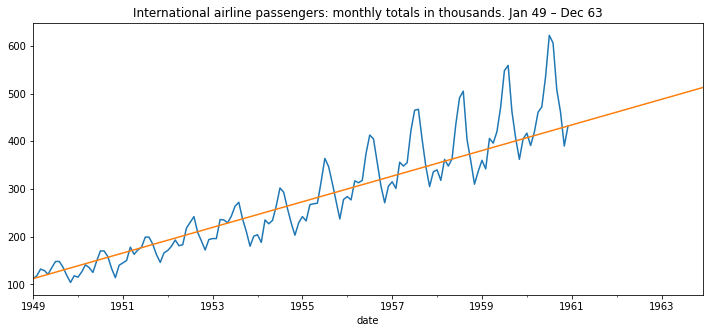

In [7]:
s0=passengers.values.flatten()[0]#первое и последнее значение количества пассажиров в начальных данных
s144=passengers.values.flatten()[-1]

last12=passengers.values.flatten()  #формируем столбец нового количества пассажиров за 1961-1963
last12_list=last12.tolist()
new_last_tr=[]
T=passengers.shape[0]
last_T=last12_list[-1]
start=last12_list[0]
for i in range (12*n): 
    new_last_tr.append(last_T+(last_T-start)/(T+i-1))
    last_T=new_last_tr[-1]

new_trend=np.array(new_last_tr).flatten()

tr=np.linspace(s0,s144,passengers.shape[0])#трендом для данных до 1960
trend=np.append(tr,new_trend)#полный столбец со значением тренда
new_df["trend"]=trend

new_df['num_passengers'].plot(figsize=(12,5)) #отрисовываем
new_df["trend"].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63')
plt.plot()
plt.show()

In [15]:
trend

array([112.        , 114.23776224, 116.47552448, 118.71328671,
       120.95104895, 123.18881119, 125.42657343, 127.66433566,
       129.9020979 , 132.13986014, 134.37762238, 136.61538462,
       138.85314685, 141.09090909, 143.32867133, 145.56643357,
       147.8041958 , 150.04195804, 152.27972028, 154.51748252,
       156.75524476, 158.99300699, 161.23076923, 163.46853147,
       165.70629371, 167.94405594, 170.18181818, 172.41958042,
       174.65734266, 176.8951049 , 179.13286713, 181.37062937,
       183.60839161, 185.84615385, 188.08391608, 190.32167832,
       192.55944056, 194.7972028 , 197.03496503, 199.27272727,
       201.51048951, 203.74825175, 205.98601399, 208.22377622,
       210.46153846, 212.6993007 , 214.93706294, 217.17482517,
       219.41258741, 221.65034965, 223.88811189, 226.12587413,
       228.36363636, 230.6013986 , 232.83916084, 235.07692308,
       237.31468531, 239.55244755, 241.79020979, 244.02797203,
       246.26573427, 248.5034965 , 250.74125874, 252.97

<div class="alert alert-info">

<h3> Задание 3</h3>
<p></p>
В результате выполнения предыдущих заданий вы получили две модели, каждая из которых описывает только одну из компонент ряда: либо тренд, либо сезонность. Попробуем их объединить. Для этого:
    <p></p>
    <li>вычтите из исходного ряда трендовую составляющую, постройте коррелограмму полученного ряда остатков;</li>
    <li>для ряда остатков постройте наивную сезонную модель.</li>
    
 Получите прогноз на 3 года вперед с помощью комбинации моделей. Результат отобразите на графике.
<p></p>
  
</div>

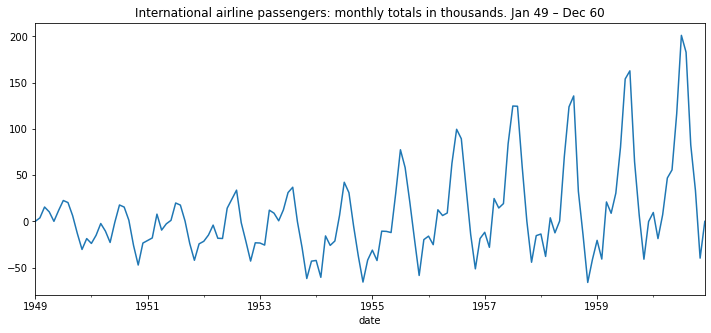

In [8]:
passengers["new"]=num_pass-tr #вычитаем из исходного ряда трендовую составляющую

passengers['new'].plot(figsize=(12,5)) #отрисовываем
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 60')
plt.plot()
plt.show()

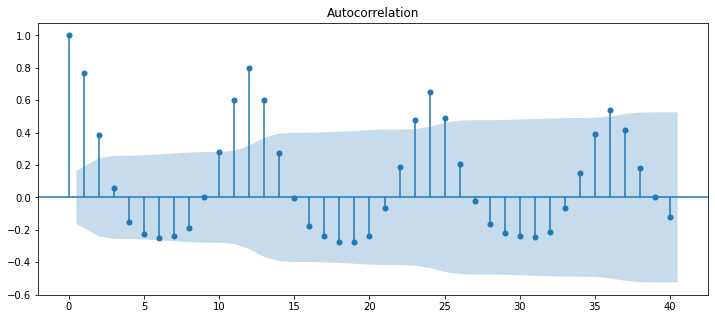

In [9]:
fig, ax = plt.subplots(figsize=(12,5)) #коррелограмма полученного ряда остатков
plot_acf(passengers['new'], lags=40, ax=ax)
plt.show()

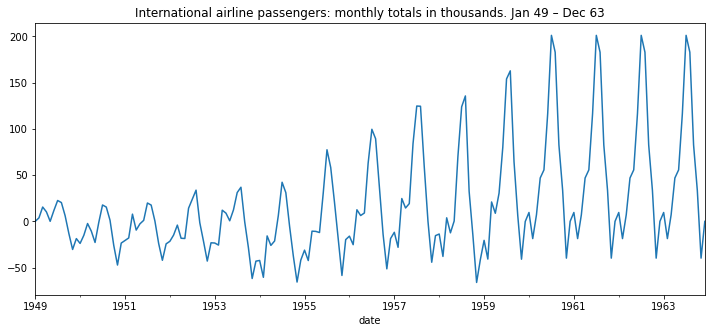

In [10]:
last12=passengers["new"].values[-12:] #для ряда остатков строим наивную сезонную модель
last12_list=last12.tolist()
new_last=last12_list*3

naiv_to_tr=np.append(passengers["new"].values,np.array(new_last).flatten())

new_df["naiv_to_tr"]=naiv_to_tr

new_df["naiv_to_tr"].plot(figsize=(12,5)) #отрисовываем
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63')
plt.plot()
plt.show()

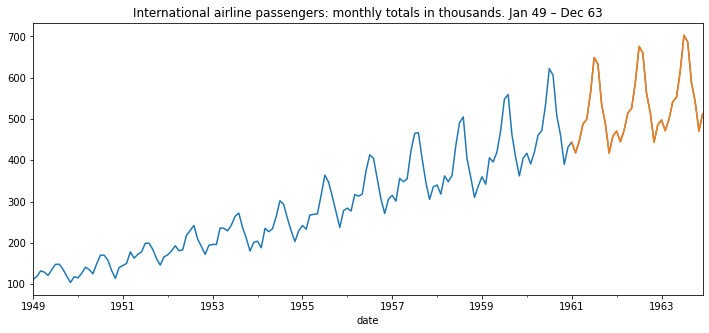

In [11]:
new_df["mixed"]=new_df["naiv_to_tr"]+trend #прогноз на 3 года вперед с помощью комбинации моделей

new_df['mixed'].plot(figsize=(12,5)) #отрисовываем
new_df['mixed'][-12*n:].plot(figsize=(12,5)) 
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63')
plt.show()

### Мультипликативная сезонность

Во временном ряду пассажирских авиаперевозок наблюдается **мультипликативная сезонность**, которая характеризуется увеличением амплитуды сезонных колебаний. В случае когда амплитуда сезонных колебаний не меняется, говорят об **аддитивной сезонности**.

Ряд с трендом и аддитивной сезонностью может быть представлен в виде суммы его компонент:

$$y(t)=b(t)+s(t)+\epsilon(t),$$

где $b(t)$ &ndash; трендовая, $s(t)$ &ndash; сезонная, а $\epsilon(t)$ &ndash; случайная компоненты ряда.

Ряд с мультипликативной сезонностью представляет собой произведение данных компонент:

$$y(t)=b(t)\times s(t)\times \epsilon(t).$$

<div class="alert alert-info">

<h3> Задание 4</h3>
<p></p>
Постройте мультипликативную модель прогнозирования, получите прогноз на 3 года вперед и отобразите результат на графике.
<p></p>
  
</div>

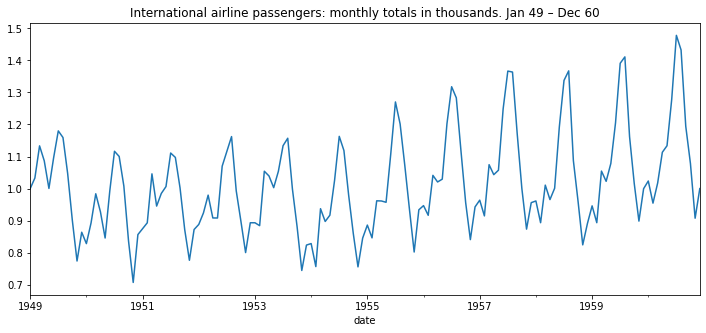

In [12]:
passengers["new for mult"]=num_pass/tr

passengers['new for mult'].plot(figsize=(12,5)) #отрисовываем
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 60')
plt.plot()
plt.show()

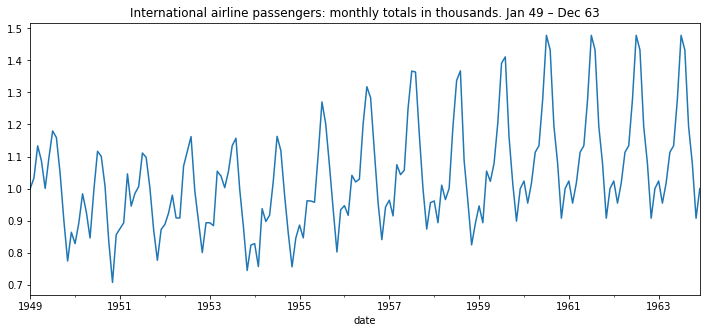

In [13]:
last12=passengers["new for mult"].values[-12:] #формируем столбец нового количества пассажиров за 1961-1963
last12_list=last12.tolist()
new_last=last12_list*3

naiv_to_tr=np.append(passengers["new for mult"].values,np.array(new_last).flatten())

new_df["naiv_to_tr2"]=naiv_to_tr

new_df["naiv_to_tr2"].plot(figsize=(12,5)) #отрисовываем
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63')
plt.plot()
plt.show()

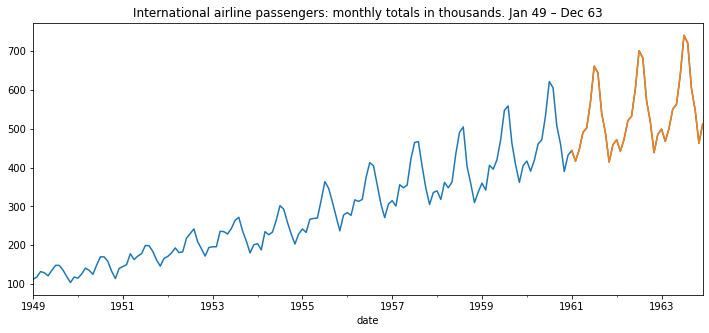

In [14]:
new_df["multiplic"]=new_df["naiv_to_tr2"]*trend

new_df['multiplic'].plot(figsize=(12,5)) #отрисовываем
new_df['multiplic'][-12*n:].plot(figsize=(12,5)) 
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63')
plt.show()